In [13]:
import torch
import torchvision
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader

### **Load dataset**

In [14]:
%%capture

training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
testing_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

### **Visualize dataset**

In [15]:
print(f"Number of sample in train set: {training_data.data.shape[0]}")
print(f"Number of sample in test set: {testing_data.data.shape[0]}")
print(f"Size of each sample: {training_data.data.shape[1]}x{training_data.data.shape[2]}")

Number of sample in train set: 60000
Number of sample in test set: 10000
Size of each sample: 28x28


Number of each class:


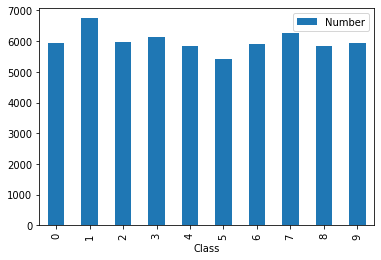

In [16]:
numClass = training_data.targets.data.unique()
numPerClass = [0 for i in range(numClass.shape[0])]
for item in training_data.targets.data:
    numPerClass[item] += 1
print(f"Number of each class:")

df = pd.DataFrame({
    "Class": [i.item() for i in numClass],
    "Number": [numPerClass[i] for i in range(len(numPerClass))]
})
df.plot(x="Class", kind="bar")

### **Preprocess**

In [47]:
def one_hot(y):
    return torch.Tensor([[1 if item==i else 0 for i in range(10)] for item in y ])

In [48]:
X_train, y_train = training_data.data, training_data.targets
X_test, y_test = testing_data.data, testing_data.targets
# Reshape: [numExample, Height, Weight] to [numExample, Deep, Height, Weight] (Because this dataset is images having a 1x28x28 size)
newShape_train = (X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
newShape_test = (X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
X_train = torch.reshape(X_train, newShape_train).type(dtype=torch.float)
X_test = torch.reshape(X_test, newShape_test).type(dtype=torch.float)
y_train, y_test = one_hot(y_train), one_hot(y_test)

### **Create a Neural network model**

In [49]:
class NeuralNetwork(nn.Module):
    def __init__(self, lr=1e-3, batch_size=64, epochs=10, printEpoch=1, Optim='SGD'):
        super(NeuralNetwork, self).__init__()
        # Hyperparameters
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.printEpoch = printEpoch
        # Model architecture
        self.Input = nn.Flatten()
        self.Hidden = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh()
        )
        self.Output = nn.Sequential(
            nn.Linear(128, 10),
            nn.Tanh()
        )

        # Define loss function
        self.lossFunc = nn.CrossEntropyLoss()
        # Define Optimizer
        if Optim.lower()=='sgd':
            self.optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        elif Optim.lower()=='adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif Optim.lower()=='rmsprop':
            self.optimizer = torch.optim.rmsprop(self.parameters(), lr=self.lr)
    
    def predict(self, X):
        # Feed forward
        Input = self.Input(X)
        Hidden = self.Hidden(Input)
        Output = self.Output(Hidden)
        return Output
    
    def train(self, X_train, y_train):
        for epoch in range(self.epochs):
            loss = 0
            for batch in range(0, X_train.shape[0] // self.batch_size):
                # Take a batch from X_train, y_train per iter
                X = X_train[batch*self.batch_size : (batch+1)*self.batch_size]
                y = y_train[batch*self.batch_size : (batch+1)*self.batch_size]

                y_pre = self.predict(X)
                # Back-prop
                loss = self.lossFunc(y_pre, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            if epoch%self.printEpoch == 0:
                print(f"--Epoch {epoch}:")
                print(f"Loss = {loss}")

    def evaluate(self, X_test, y_test, metric='accuracy'):
        y_pre = self.predict(X_test)
        # Convert oneHotVector to a list
        y_pred = [item.argmax().item() for item in y_pre]
        y_true = [item.argmax().item() for item in y_test]
        # Accuracy score
        if metric.lower()=="accuracy":
            score = 0
            for i in range(len(y_pred)):
                if y_pred[i] == y_true[i]:
                    score += 1
            print(f"Accuracy on test set: {score*1.0 / y_pre.shape[0] * 100}")
        # Precision, Recall and F1-score
        elif metric.lower()=="prf":
            precision, recall, fscore, _ = sklearn.metrics.precision_recall_fscore_support(y_true, y_pred)
            print(f"Precision/ Recall/ F1-score on test set:")
            print("--Precision:\n{}".format(precision))
            print("--Recall:\n{}".format(recall))
            print("--F1 score: {}".format(fscore))

### **Training**

In [51]:
model = NeuralNetwork(lr=5e-4, printEpoch=1, epochs=10, Optim='Adam')
model.train(X_train, y_train)

--Epoch 0:
Loss = 0.9566481113433838
--Epoch 1:
Loss = 0.9539390206336975
--Epoch 2:
Loss = 0.929846465587616
--Epoch 3:
Loss = 0.8951056003570557
--Epoch 4:
Loss = 0.9027689099311829
--Epoch 5:
Loss = 0.8879004120826721
--Epoch 6:
Loss = 0.8847787380218506
--Epoch 7:
Loss = 0.8926281929016113
--Epoch 8:
Loss = 0.8933218717575073
--Epoch 9:
Loss = 0.8712365627288818


### **Evaluate and Visualize result**

In [52]:
model.evaluate(X_test, y_test)

Accuracy on test set: 93.7


In [53]:
model.evaluate(X_test, y_test, metric="PRF")

Precision/ Recall/ F1-score on test set:
--Precision:
[0.95129225 0.95890411 0.96940928 0.90485252 0.90294957 0.9295302
 0.96166134 0.94788594 0.90456432 0.93970894]
--Recall:
[0.97653061 0.98678414 0.89050388 0.94158416 0.96639511 0.93161435
 0.94258873 0.93774319 0.89527721 0.89593657]
--F1 score: [0.96374622 0.97264438 0.92828283 0.92285298 0.93359567 0.93057111
 0.95202952 0.94278729 0.8998968  0.91730086]


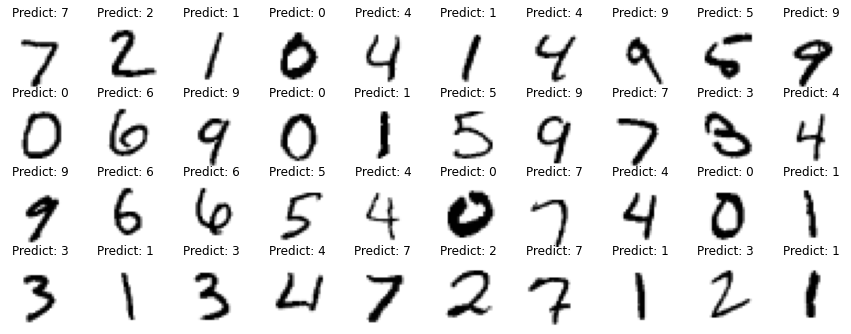

In [54]:
# PREVIEW PREDICTIONS
y_pred = model.predict(X_test)
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28, 28)),cmap=plt.cm.binary)
    plt.title(f"Predict: {y_pred[i].argmax().item()}")
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()